In [8]:
# try frobenius method??


# test residuals to see if (x, t) solution satisfies original differential equations

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from cswe_harm import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


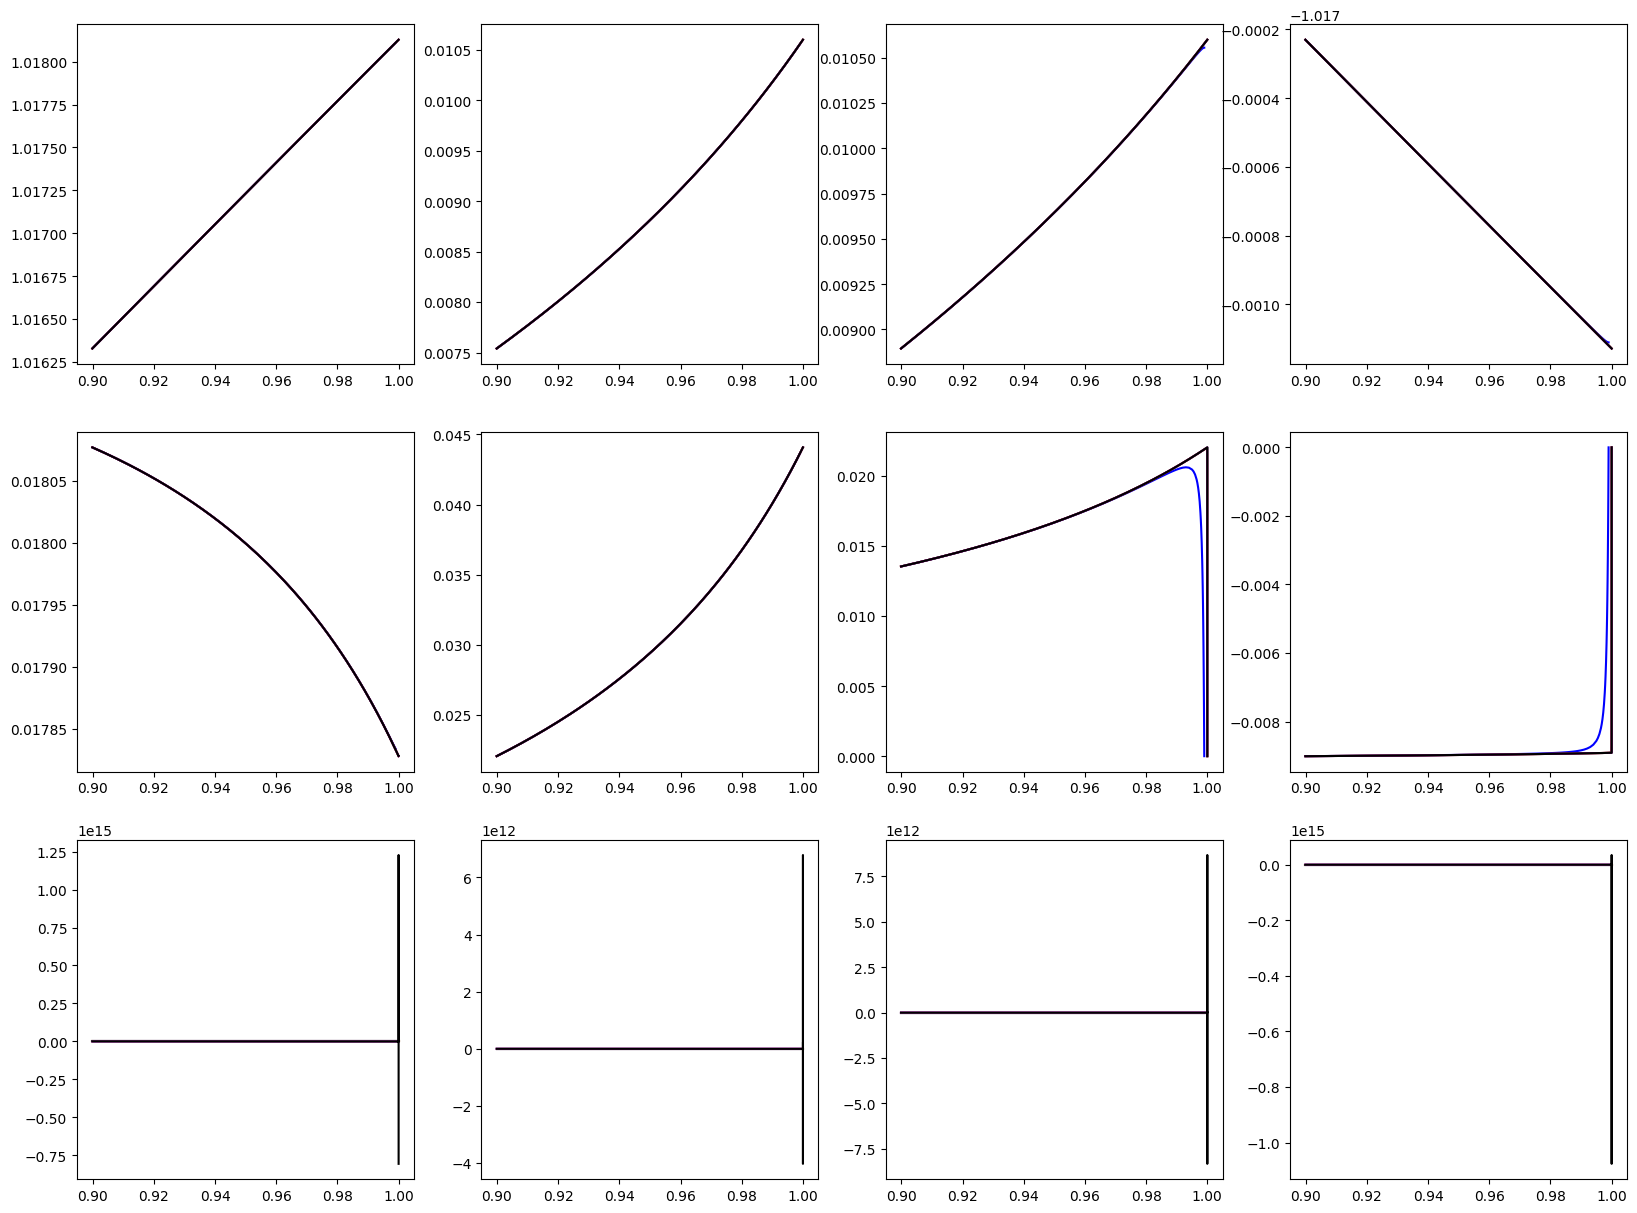

In [9]:
csweharm = CSWEHarm()
csweharm.debug= False
csweharm.h0 = 0.1
csweharm.r = 0.24

fig, axs = plt.subplots(3, 4, figsize=(20, 15))

cols = ['b', 'r', 'g', 'm', 'k', 'c']
sns = [1e-3, 1e-5, 1e-7, 1e-9, 1e-11]
for bnd_i in range(len(sns)):
    csweharm.domain_reduction = sns[bnd_i]
    csweharm.solve_LO_reduced_domain()

    st =  np.argmin(abs(csweharm.y0.x - 0.999))
    st =  np.argmin(abs(csweharm.y0.x - 0.9))

    for i in range(4):
        axs[0, i].plot(csweharm.y0.x[st:], csweharm.y0.y[i][st:], cols[bnd_i])
        axs[1, i].plot(csweharm.y0.x[st:], csweharm.y0.sol(csweharm.y0.x, nu=1)[i][st:], cols[bnd_i])
        axs[2, i].plot(csweharm.y0.x[st:], csweharm.y0.sol(csweharm.y0.x, nu=2)[i][st:], cols[bnd_i])


plt.show()

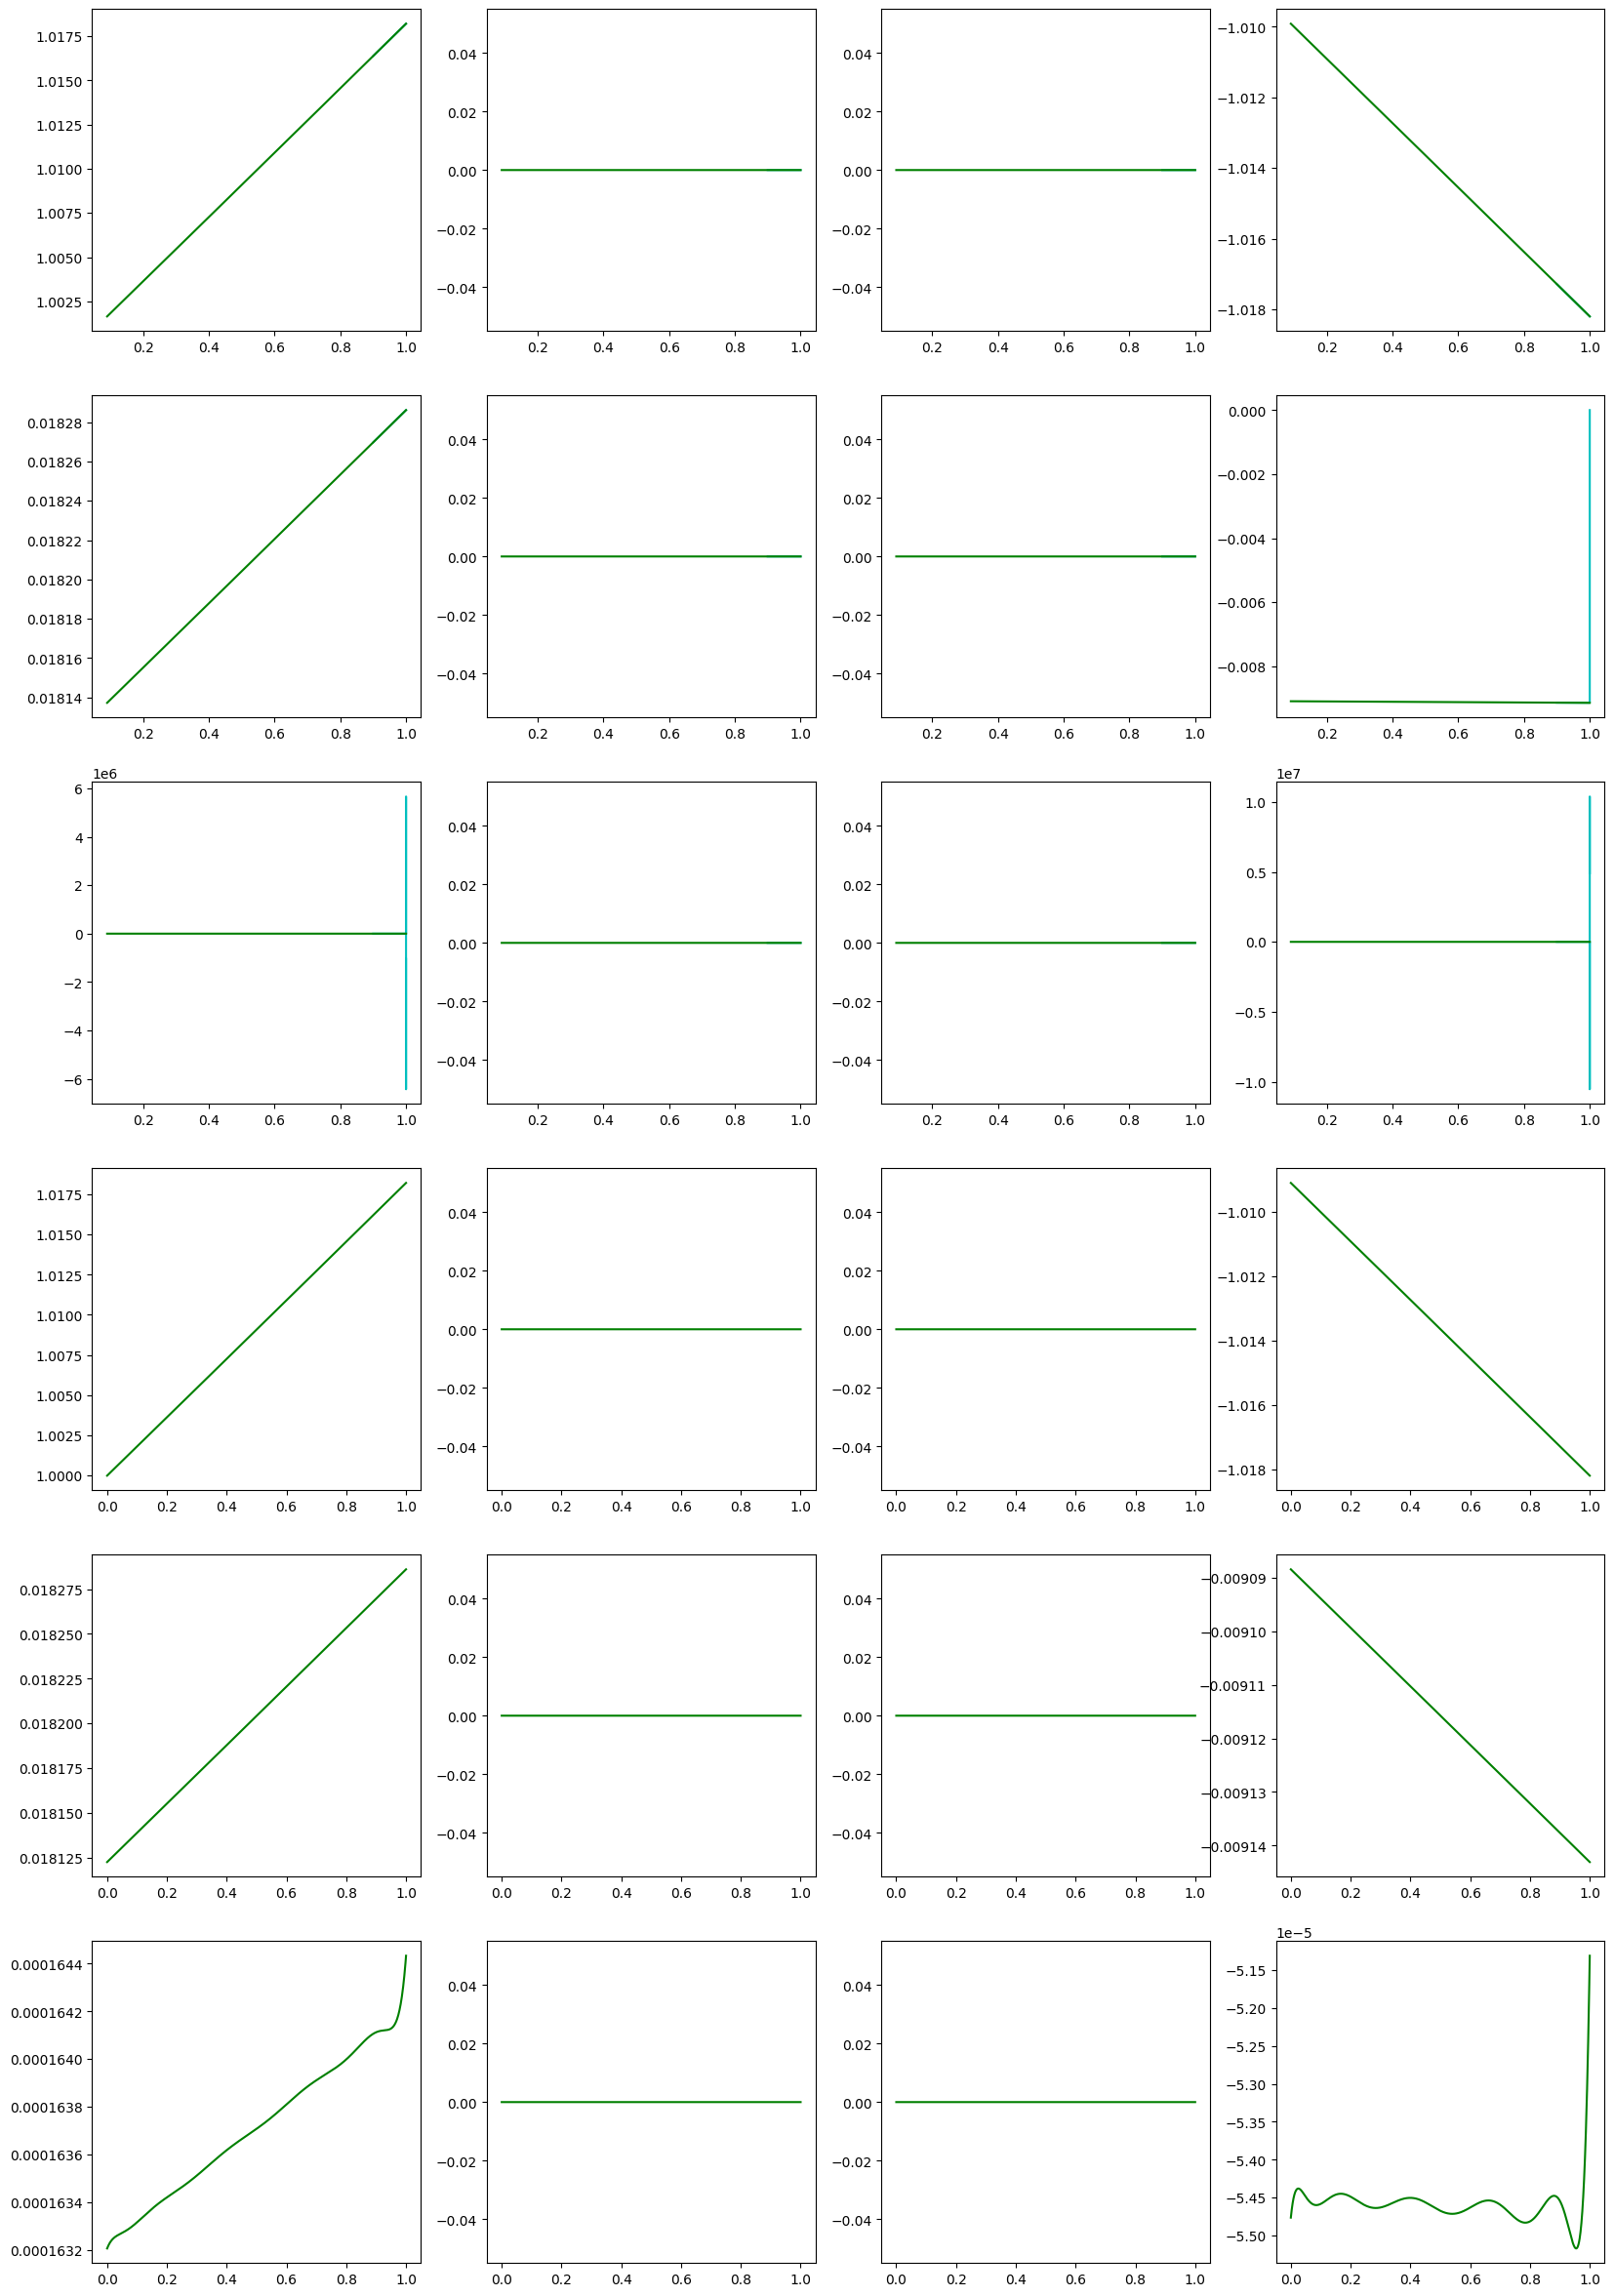

In [15]:
csweharm = CSWEHarm()
csweharm.debug= False
csweharm.h0 = 0.1
csweharm.r = 0

fig, axs = plt.subplots(6, 4, figsize=(20, 30))

cols = ['b', 'r', 'g', 'm', 'k', 'c']
sns = [1e-3, 1e-5, 1e-7, 1e-9, 1e-11]

cols = ['c']
cols2=['g']
sns = [1e-7]
for bnd_i in range(len(sns)):
    csweharm.small_number = sns[bnd_i]
    csweharm.solve_LO_small_number()

    st =  np.argmin(abs(csweharm.y0.x - 0.999))
    st =  np.argmin(abs(csweharm.y0.x - 0.9))

    for i in range(4):
        axs[0, i].plot(csweharm.y0.x[st:], csweharm.y0.y[i][st:], cols[bnd_i])
        axs[1, i].plot(csweharm.y0.x[st:], csweharm.y0.sol(csweharm.y0.x, nu=1)[i][st:], cols[bnd_i])
        axs[2, i].plot(csweharm.y0.x[st:], csweharm.y0.sol(csweharm.y0.x, nu=2)[i][st:], cols[bnd_i])

    csweharm.interpolate_LO()
    for i in range(4):
        axs[0, i].plot(csweharm.xi[st:], csweharm.y0i(csweharm.xi)[i][st:], cols2[bnd_i])
        axs[1, i].plot(csweharm.xi[st:], csweharm.y0i(csweharm.xi, nu=1)[i][st:], cols2[bnd_i])
        axs[2, i].plot(csweharm.xi[st:], csweharm.y0i(csweharm.xi, nu=2)[i][st:], cols2[bnd_i])

        axs[3, i].plot(csweharm.y0.x, csweharm.y0i(csweharm.y0.x)[i], cols2[bnd_i])
        axs[4, i].plot(csweharm.y0.x, csweharm.y0i(csweharm.y0.x, nu=1)[i], cols2[bnd_i])
        axs[5, i].plot(csweharm.y0.x, csweharm.y0i(csweharm.y0.x, nu=2)[i], cols2[bnd_i])


plt.show()

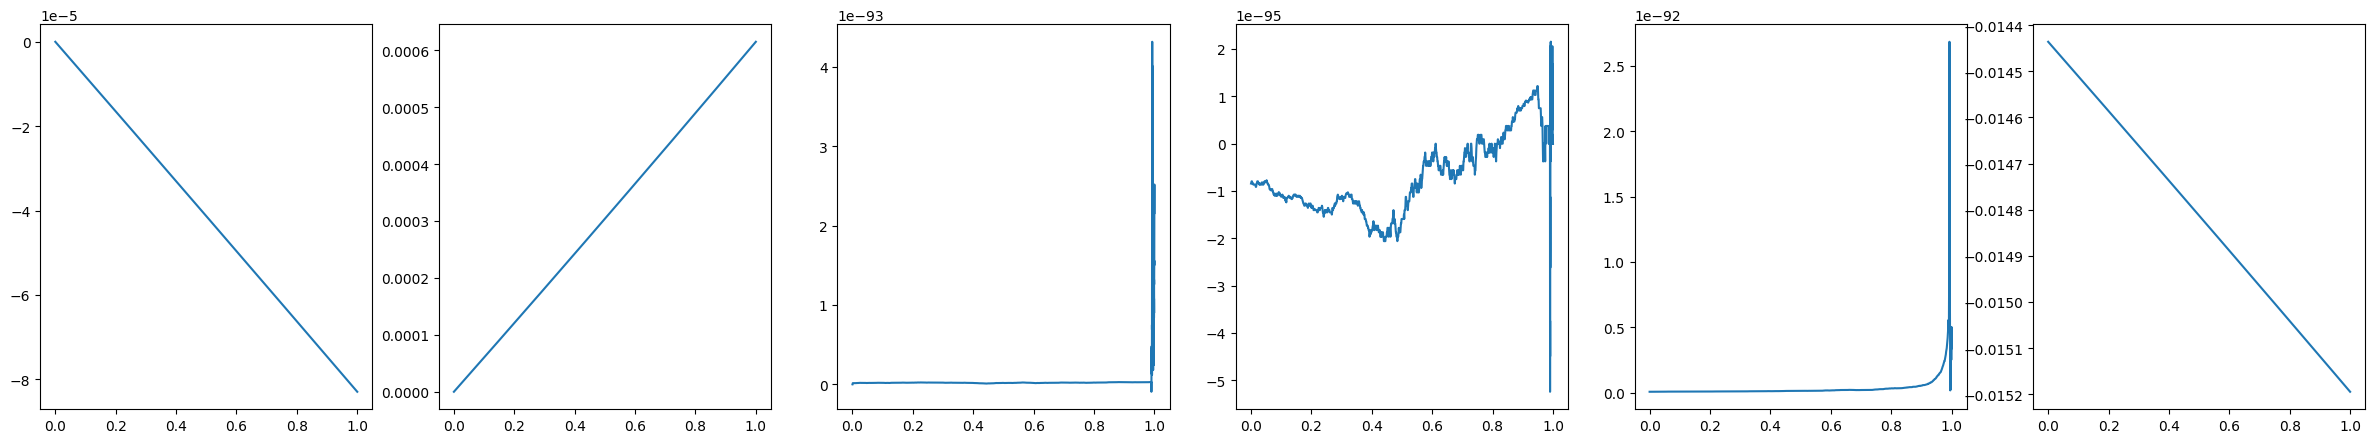

In [16]:
csweharm.debug = False
csweharm.solve_FO_small_number_interpolation_based()


fig, axs = plt.subplots(1, 6, figsize=(30, 5))
for i in range(6):
    axs[i].plot(csweharm.x, csweharm.y1.sol(csweharm.x)[i])

plt.show()


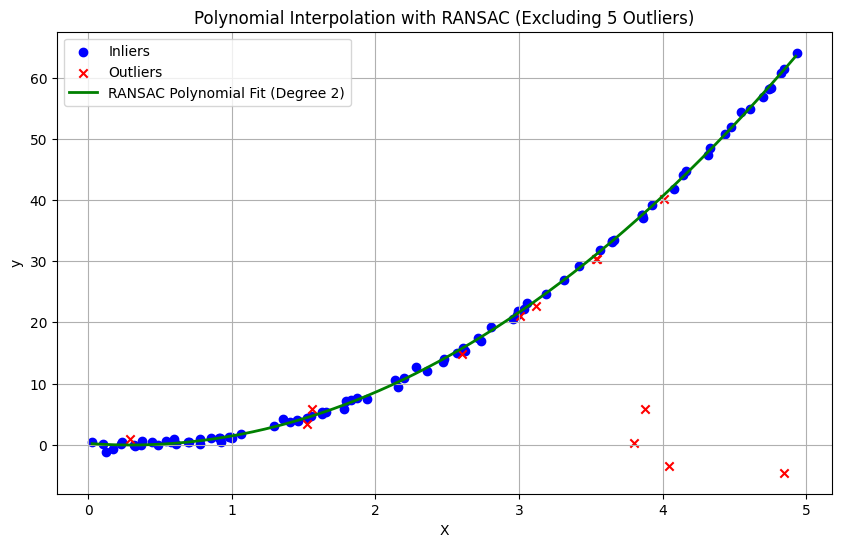

RANSAC estimated coefficients (for X^0, X^1, X^2, ...): [ 0.         -1.7377553   2.95980821]
RANSAC estimated intercept: 0.20705732918769826
Number of inliers found by RANSAC: 87
Number of outliers found by RANSAC: 13


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# --- 1. Generate synthetic data with outliers ---
np.random.seed(42)
n_samples = 100
n_outliers = int(0.05 * n_samples) # 5% outliers as requested

# Generate true polynomial data (e.g., a quadratic function)
true_coeffs = [0.5, -2, 3] # Coefficients for 3x^2 - 2x + 0.5
X = np.sort(5 * np.random.rand(n_samples, 1), axis=0)
y = true_coeffs[0] + true_coeffs[1] * X + true_coeffs[2] * X**2 + 0.5 * np.random.randn(n_samples, 1)

# Add outliers
outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
y[outlier_indices] = 20 * np.random.rand(n_outliers, 1) - 10 # Random large values for outliers

# --- 2. Define the polynomial degree ---
polynomial_degree = 2 # For a quadratic fit

# --- 3. Create a pipeline for polynomial features and RANSAC regression ---
# The base estimator for RANSAC is a simple LinearRegression model,
# which will operate on the polynomial features.
# max_trials: Maximum number of random samples chosen.
# min_samples: Minimum number of samples chosen randomly in each iteration.

# stop_n_inliers: Stop RANSAC if at least this many inliers are found.
# stop_score: Stop RANSAC if the score (e.g., R^2) is at least this value.
# residual_threshold: Maximum residual for a data point to be classified as an inlier.
#                     This is crucial for defining what an "outlier" is.
#                     A good starting point is often a multiple of the expected noise standard deviation.
#                     Here, we'll use a value derived from the original noise level.
#                     Adjust this based on your data's noise characteristics.

# For demonstration, let's estimate a reasonable residual_threshold
# based on the original noise (0.5 * std_dev of random noise)
estimated_noise_std = 0.5
ransac = RANSACRegressor(
    estimator=LinearRegression(),
    min_samples=polynomial_degree + 1, # Need at least degree + 1 points to fit a polynomial
    residual_threshold=2 * estimated_noise_std, # Points with residuals > this are outliers
    random_state=42,
    stop_n_inliers=n_samples - n_outliers # Stop if we find roughly the expected number of inliers
)

# Create the pipeline: first transform X to polynomial features, then apply RANSAC
model = make_pipeline(PolynomialFeatures(degree=polynomial_degree), ransac)

# --- 4. Fit the model ---
model.fit(X, y)

# --- 5. Get inliers and outliers from the RANSAC model ---
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict values using the fitted RANSAC model
line_X = np.arange(X.min(), X.max(), 0.01)[:, np.newaxis]
line_y_ransac = model.predict(line_X)

# --- 6. Visualize the results ---
plt.figure(figsize=(10, 6))
plt.scatter(X[inlier_mask], y[inlier_mask], color='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='red', marker='x', label='Outliers')
plt.plot(line_X, line_y_ransac, color='green', linewidth=2, label=f'RANSAC Polynomial Fit (Degree {polynomial_degree})')

# Optionally, fit a standard Linear Regression for comparison
# model_linear = make_pipeline(PolynomialFeatures(degree=polynomial_degree), LinearRegression())
# model_linear.fit(X, y)
# line_y_linear = model_linear.predict(line_X)
# plt.plot(line_X, line_y_linear, color='purple', linestyle='--', linewidth=2, label='Standard Linear Fit (for comparison)')


plt.title(f'Polynomial Interpolation with RANSAC (Excluding {n_outliers} Outliers)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Print the coefficients of the RANSAC-fitted model
# The coefficients are from the LinearRegression estimator inside RANSACRegressor
# after it has been fit on the inliers.
# Note: The coefficients are for the polynomial features (X^0, X^1, X^2, ...)
print(f"RANSAC estimated coefficients (for X^0, X^1, X^2, ...): {ransac.estimator_.coef_[0]}")
print(f"RANSAC estimated intercept: {ransac.estimator_.intercept_[0]}")
print(f"Number of inliers found by RANSAC: {np.sum(inlier_mask)}")
print(f"Number of outliers found by RANSAC: {np.sum(outlier_mask)}")
